In [1]:
import os
import sys

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import seaborn_image as isns

import keras
from keras.layers import *
from keras.models import Model
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf

In [2]:
tf.version.VERSION

'2.8.4'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Preparation

In [119]:
train_data_csv = pd.read_csv('data/train.csv')

In [120]:
train_featrues, train_targets = (train_data_csv.drop(['label'], axis=1), train_data_csv.label)

In [121]:
train_images = train_featrues.values.astype('float32').reshape(-1, 28, 28, 1)

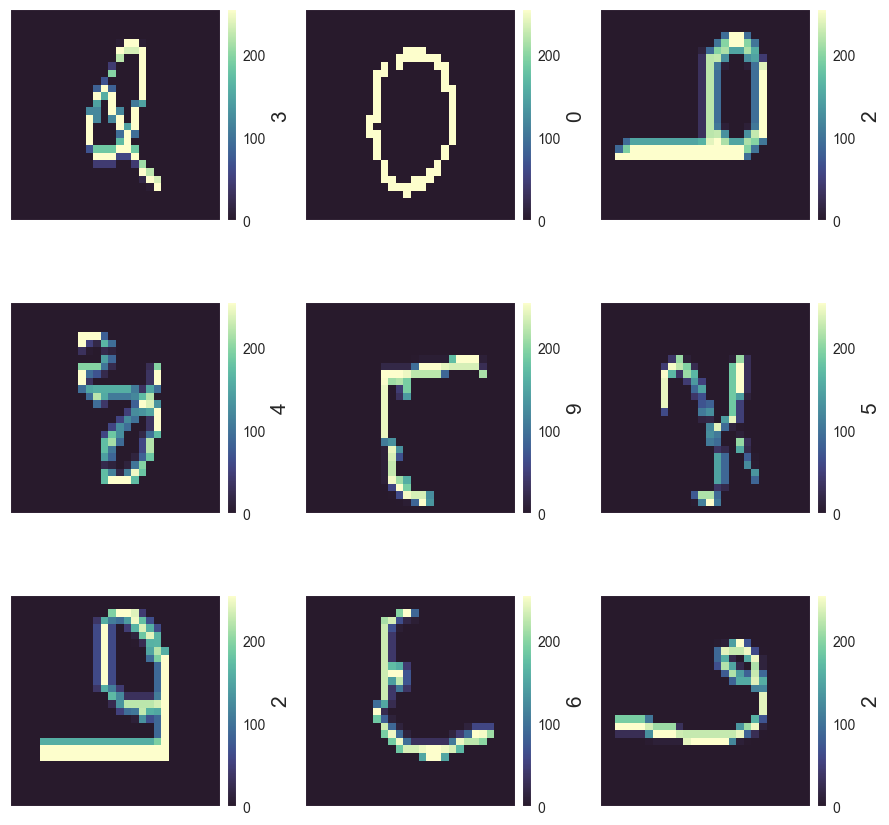

In [123]:
ints = np.random.randint(0, train_images.shape[0], 9)
_ = isns.ImageGrid([np.flipud(train_images[i, :, :, :].reshape(28, 28)) for i in ints],
                   cbar_label=[f'{train_targets[i]}' for i in ints],
                   col_wrap=3)

In [124]:
train_targets = tf.keras.utils.to_categorical(train_targets, num_classes=10, dtype='float32')

In [125]:
train_targets.shape

(60000, 10)

In [126]:
train_images.shape

(60000, 28, 28, 1)

## 2. Experiments

In [10]:
def scale_and_augment(input):
    x = Rescaling(1./255)(input)
    x = RandomRotation(.042, fill_mode='constant')(x)
    x = RandomTranslation(.25, .25, fill_mode='constant')(x)
    x = RandomZoom((-.2, .3), fill_mode='constant')(x)

    return x



def conv_block(input, depth, kernel_size, num_kernels, activation, batchnorm):
    for _ in range(depth):
        x = Conv2D(filters=num_kernels,
                   kernel_size=kernel_size,
                   padding='same',
                   )(input)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)

    return x


In [11]:
def build_cnn_1(weights=None):
    name = 'cnn_1'
    inputs = Input(shape=train_images.shape[1:])

    x = scale_and_augment(inputs)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=64,
                   activation='relu',
                   batchnorm=True)


    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=128,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=256,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

    if weights is not None:
        model.load_weights(weights)

    return model

In [12]:
def build_cnn_2(weights=None):
    name = 'cnn_2'
    inputs = Input(shape=train_images.shape[1:])

    x = scale_and_augment(inputs)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=16,
                   activation='relu',
                   batchnorm=True)


    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=32,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=64,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=128,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

    if weights is not None:
        model.load_weights(weights)

    return model

In [13]:
def build_cnn_3(weights=None):
    name = 'cnn_3'
    inputs = Input(shape=train_images.shape[1:])

    x = scale_and_augment(inputs)

    x1 = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=32,
                   activation='swish',
                   batchnorm=True)

    x2 = conv_block(input=x,
               depth=2,
               kernel_size=5,
               num_kernels=32,
               activation='swish',
               batchnorm=True)

    x2 = conv_block(input=x2,
               depth=2,
               kernel_size=3,
               num_kernels=32,
               activation='swish',
               batchnorm=True)

    x3 = conv_block(input=x,
               depth=1,
               kernel_size=7,
               num_kernels=32,
               activation='swish',
               batchnorm=True)


    x = Concatenate()([x1, x2, x3])

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.2)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=128,
                   activation='swish',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.2)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=256,
                   activation='swish',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='swish')(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

    if weights is not None:
        model.load_weights(weights)

    return model, name

In [14]:
model, name = build_cnn_3()

In [15]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 28, 28, 1)    0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 28, 28, 1)   0           ['rescaling[0][0]']              
 n)                                                                                               
                                                                                                  
 random_translation (RandomTran  (None, 28, 28, 1)   0           ['random_rotation[0][0]']    

In [127]:
ds_train_set = tf.data.Dataset.from_tensor_slices((train_images, train_targets))

In [109]:
def brightness_augment(image, target):
    image = tf.math.multiply(image, tf.random.uniform(shape=[], minval=.9, maxval=1))

    return image, target

In [110]:
SPLIT = .15
BATCH_SIZE = 2048

ds_eval = ds_train_set.take(round(train_targets.shape[0]*SPLIT))
ds_train = ds_train_set.skip(round(train_targets.shape[0]*SPLIT))

ds_train = ds_train.map(brightness_augment)

ds_train = ds_train.batch(BATCH_SIZE)
ds_eval = ds_eval.batch(BATCH_SIZE)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)

In [20]:
# history = model.fit(
#                     ds_train,
#                     validation_data=ds_eval,
#                     epochs=150,
#                     callbacks=[ModelCheckpoint(f'./models/{name}/weights_best.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)]
#                     )

In [21]:
# plt.plot(history.history['loss'], 'g')
# plt.plot(history.history['val_loss'], 'r')
# plt.title(f'{name} Loss across epochs\n')
# plt.ylabel('Loss')
# plt.xlabel('# epoch')
# plt.legend(['train', 'test'], loc='lower right')

In [22]:
# model.load_weights(f'./models/{name}/weights_best.h5')
#
# scores = model.evaluate(ds_eval)
#
# os.makedirs(f'./models/{name}/model', exist_ok=True)
# model.save(filepath=f'./models/{name}/model', save_format='tf')
#
# print("done training!")
#
# original_stdout = sys.stdout
# with open(f'./models/{name}/training.info', 'w') as f:
#     sys.stdout = f
#
#     print(f'\n\n***MODEL SUMMARY***\nacc: {scores[2]}')
#     print(model.summary())
#     print('\n\n****FLOPS***\n')
#
#     sys.stdout = original_stdout
#
# print('done experiment!')

## 3. Ensemble + Pseudo Labelling

In [41]:
test_data_csv = pd.read_csv('data/test.csv')
test_images = test_data_csv.drop(['id'], axis=1).values.astype('float32').reshape(-1, 28, 28, 1)

In [42]:
dig_data_csv = pd.read_csv('data/Dig-MNIST.csv')

In [25]:
dig_data_csv

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10236,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10238,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
def train_n_models(n, dataset, prefix, split, epochs):
    for i in range(n):
        ds = dataset.shuffle(len(dataset), reshuffle_each_iteration=False)

        SPLIT = split
        BATCH_SIZE = 2048

        ds_eval = ds.take(round(train_targets.shape[0] * SPLIT))
        ds_train = ds.skip(round(train_targets.shape[0] * SPLIT))

        ds_train = ds_train.map(brightness_augment)

        ds_train = ds_train.batch(BATCH_SIZE)
        ds_eval = ds_eval.batch(BATCH_SIZE)
        AUTOTUNE = tf.data.AUTOTUNE
        ds_train = ds_train.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)

        model, _ = build_cnn_3()

        history = model.fit(
            ds_train,
            validation_data=ds_eval,
            epochs=epochs,
            callbacks=[
                ModelCheckpoint(f'./models/{prefix}/weights_best_{i}.h5', monitor='val_accuracy', save_best_only=True, mode='max',
                                verbose=1)]
        )

        model.load_weights(f'./models/{prefix}/weights_best_{i}.h5')

        os.makedirs(f'./models/{prefix}/{i}/model', exist_ok=True)
        model.save(filepath=f'./models/{prefix}/{i}/model', save_format='tf')

In [ ]:
train_n_models(n=3,
               dataset=ds_train_set,
               prefix='base_model',
               split=.05,
               epochs=300)

In [145]:
# check
i = 0
model, _ = build_cnn_3(f'./models/final_models/weights_best_{i}.h5')

In [146]:
test_images.shape

(5000, 28, 28, 1)

In [147]:
preds = model.predict(test_images)

In [148]:
test_targets = np.argmax(preds, axis=1)

In [150]:
ids_confident = np.argwhere((preds > .95).any(axis=1))

In [151]:
test_images_confident, test_targets_confident = (test_images[ids_confident].astype('float32'), np.squeeze(test_targets[ids_confident]))

In [152]:
test_images_confident = test_images_confident.reshape(-1, 28, 28, 1)

In [153]:
test_images_confident.shape

(4720, 28, 28, 1)

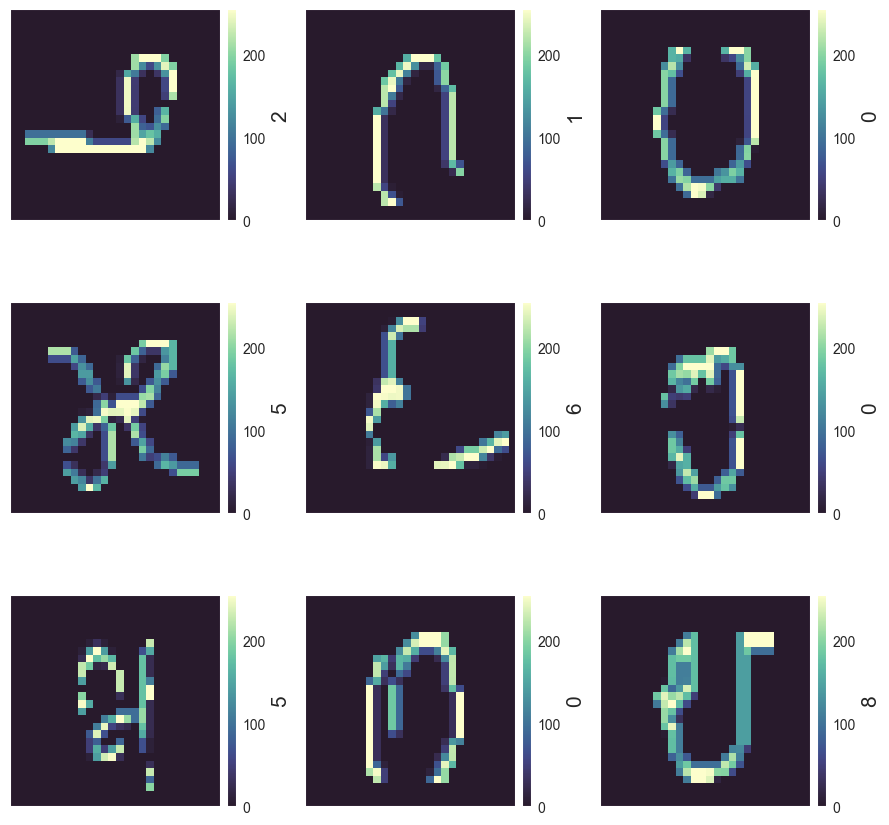

In [154]:
ints = np.random.randint(0, test_images_confident.shape[0], 9)
_ = isns.ImageGrid([np.flipud(test_images_confident[i, :, :, :].reshape(28, 28)) for i in ints],
                   cbar_label=[f'{test_targets_confident[i]}' for i in ints],
                   col_wrap=3)

In [155]:
test_targets_confident = tf.keras.utils.to_categorical(test_targets_confident, num_classes=10, dtype='float32')

In [156]:
ds_test_confident = tf.data.Dataset.from_tensor_slices((test_images_confident, test_targets_confident))

In [157]:
ds_pseudo_label = ds_train_set.concatenate(ds_test_confident)

In [158]:
len(ds_pseudo_label)

64720

In [165]:
train_n_models(n=3,
               dataset=ds_pseudo_label,
               prefix='pseudo_label',
               split=.015,
               epochs=300)

Epoch 1/300
32/32 [==============================] - ETA: 0s - loss: 0.8656 - accuracy: 0.7204
Epoch 1: val_accuracy improved from -inf to 0.16556, saving model to ./models/pseudo_label\weights_best_0.h5
32/32 [==============================] - 10s 143ms/step - loss: 0.8656 - accuracy: 0.7204 - val_loss: 2.4840 - val_accuracy: 0.1656
Epoch 2/300
32/32 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9297
Epoch 2: val_accuracy improved from 0.16556 to 0.18556, saving model to ./models/pseudo_label\weights_best_0.h5
32/32 [==============================] - 4s 122ms/step - loss: 0.2188 - accuracy: 0.9297 - val_loss: 3.0751 - val_accuracy: 0.1856
Epoch 3/300
32/32 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9555
Epoch 3: val_accuracy did not improve from 0.18556
32/32 [==============================] - 4s 119ms/step - loss: 0.1398 - accuracy: 0.9555 - val_loss: 3.5048 - val_accuracy: 0.1656
Epoch 4/300
32/32 [==============================

In [167]:
model_0 = keras.models.load_model('C:/KBData/01_PROJECT/00_GIT/ELTE/data_mining/comp_3/models/pseudo_label/0/model')
model_1 = keras.models.load_model('C:/KBData/01_PROJECT/00_GIT/ELTE/data_mining/comp_3/models/pseudo_label/1/model')

In [169]:
preds_0 = model_0.predict(test_images)
preds_1 = model_0.predict(test_images)